<h1>80 - 20 Rule Analysis</h1>
<h3>Goals for this project:</h3>
<ul><li>Influencers in the self-help industry have long been touting the belief that "80 percent of the results come from 20 percent of the effort." It would be informative to check this belief statistically.</li><li>Let's test the 80-20 rule by examining the views per video of different YouTubers. Then we will examine the likes per post of different Instagram accounts.</li></ul>

In [1]:
# get my api key
import os
import pandas as pd
import math
import googleapiclient.discovery
import googleapiclient.errors

from config import API_KEY as api_key

youtube = googleapiclient.discovery.build("youtube", "v3", developerKey = api_key)

<h1>Get the data with API calls</h1>
<h3>Notes:</h3>
<ul><li>We need a function that will read video view counts from one page of a channel's Uploads playlist.</li></ul>

In [11]:
def getResultsFromOnePage(uploads_playlist_id, next_page_token=None):
    # get the Upload playlist's videos
    videos_request = youtube.playlistItems().list(part="contentDetails", 
                                                  playlistId=uploads_playlist_id,
                                                  maxResults=50,
                                                  pageToken=next_page_token)
    videos_response = videos_request.execute()
    
    # grab the video IDs
    video_ids = [response_item['contentDetails']['videoId'] 
                 for response_item in videos_response['items']]
    
    video_ids_str = ""
    for v_id in video_ids:
        video_ids_str = video_ids_str + v_id + ","
    video_ids_str = video_ids_str.rstrip(",")
    
    # get the desired information from each of the videos
    views_request = youtube.videos().list(part="snippet,statistics", 
                                          id=video_ids_str, 
                                          maxResults=50)
    views_response = views_request.execute()
    
    video_titles, video_views, errors = [], [], []
    for response_item in views_response['items']:
        try:
            video_titles.append(response_item['snippet']['title'])
            video_views.append(int(response_item['statistics']['viewCount']))
        except:
            errors.append(response_item['snippet']['title'])
    views = pd.Series(video_views, index=video_titles)
    
    return views, errors, videos_response

<ul><li>The function below will call the previous one, and aggregate the results for the given channel ID.</li></ul>

In [14]:
def getVideoViews(channel_id):
    # get the desired YouTube channel's information
    channel_request = youtube.channels().list(part="contentDetails", 
                                              id=channel_id, 
                                              maxResults=50)
    channel_response = channel_request.execute()
    
    # grab the Uploads playlist
    uploads_playlist_id = channel_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    views, errors, videos_response = getResultsFromOnePage(uploads_playlist_id, next_page_token=None)
    
    while 'nextPageToken' in videos_response.keys():
        next_page_token = videos_response['nextPageToken']
        vw, err, videos_response = getResultsFromOnePage(uploads_playlist_id, 
                                                         next_page_token=next_page_token)
        pd.concat([views, vw])
    
    return views

<h1>Analyze the Data</h1><h3>Notes:</h3><ul><li>Let's test our function on TensorFlow's YouTube channel.</li></ul>

In [16]:
views = getVideoViews("UC0rqucBdTuFTjJiefW5t-IQ") # TensorFlow's YouTube channel

<ul><li>How many videos comprise 20% of the video count?</li><li>To find this, we need to calculate the combined views of the highest-viewed 20% of videos (worst-case scenario).</li></ul>

In [17]:
twenty_percent = math.floor(len(views) * .2)
twenty_percent

10

In [18]:
twenty_perc_views = views.sort_values(ascending=False).iloc[:twenty_percent].sum()

<ul><li>Is this at least 80% of the total channel views?</li></ul>

In [19]:
twenty_perc_views / views.sum()

0.9894372885946447

<ul><li>Well, the 80-20 rule does apply for TensorFlow.</li><li>Now let's check the 80-20 rule for other YouTubers. We will collect the data in a Pandas DataFrame.</li><li>We need a wrapper function for the process we did for the Youtube channel above.</li></ul>

In [21]:
def getPercViewsDividedByTotalViews(channel_id, percentage_to_check = 20):
    views = getVideoViews(channel_id)
    perc = math.floor(len(views) * percentage_to_check/100)
    perc_views = views.sort_values(ascending=False).iloc[0:perc].sum()
    return perc_views / views.sum() * 100

<ul><li>Collect channel IDs for Gaming channels in the US.</li></ul>

In [22]:
request = youtube.search().list(part="snippet",
                                type="channel",
                                order="viewCount",
                                maxResults=50,
                                regionCode="US",
                                q="gaming")
response = request.execute()

channel_list = [{'channel_id' : response_item['snippet']['channelId'],
                 'channel_name' : response_item['snippet']['channelTitle']} for response_item in response['items']]
channel_list

[{'channel_id': 'UCjgqQdZXoUMbKagBbgfc2Wg', 'channel_name': 'Sapro Gaming'},
 {'channel_id': 'UCi2y7o_0oQoPvnSpGtcEshw',
  'channel_name': 'Nappy Boy Gaming'},
 {'channel_id': 'UCGGF6J6IUgB_K2_y2Rwh2Cw', 'channel_name': 'Skvala Gaming'},
 {'channel_id': 'UCWXXAjBRaEpQdxKvDMexJBg', 'channel_name': 'Strat Gaming'},
 {'channel_id': 'UCa7I1l-I8L5ZfmxehEyuTTg', 'channel_name': 'TEJA FF GAMING'},
 {'channel_id': 'UCoQZ-XABu1ztHpJGez_q35Q',
  'channel_name': 'Coalition Gaming'},
 {'channel_id': 'UC1QEcJhBv7jYn3l8N_waTBQ', 'channel_name': 'Daxua Gaming'},
 {'channel_id': 'UCdsFAHmmnChXh4H409FuQ4A',
  'channel_name': 'Alles Ava Gaming'},
 {'channel_id': 'UCnxubBCPlg0hHdZw_UehrTw',
  'channel_name': 'Rincón de Varo - Hardware & PC Gaming'},
 {'channel_id': 'UCpPJaHR_s3qYSCzry78G7lg',
  'channel_name': 'MrBeast Gaming Brasil'},
 {'channel_id': 'UCfhVJhlbNp1y7X8sI1CUbHA', 'channel_name': 'ZGOD GAMING'},
 {'channel_id': 'UClVvo0usLQKZTDLHci8ODkQ',
  'channel_name': 'Raging Raccoon Gaming'},
 {'chan

In [23]:
eighty_twenty_check_results = pd.DataFrame(
                                   {'Channel' : [channel["channel_name"] for channel in channel_list],
                                    'ID' : [channel["channel_id"] for channel in channel_list]})
eighty_twenty_check_results['Result'] = eighty_twenty_check_results.ID.apply(
                                    getPercViewsDividedByTotalViews)
eighty_twenty_check_results

,Channel,ID,Result
0,Sapro Gaming,UCjgqQdZXoUMbKagBbgfc2Wg,48.162864
1,Nappy Boy Gaming,UCi2y7o_0oQoPvnSpGtcEshw,52.394360
2,Skvala Gaming,UCGGF6J6IUgB_K2_y2Rwh2Cw,44.121998
3,Strat Gaming,UCWXXAjBRaEpQdxKvDMexJBg,65.231346
4,TEJA FF GAMING,UCa7I1l-I8L5ZfmxehEyuTTg,82.979773
5,Coalition Gaming,UCoQZ-XABu1ztHpJGez_q35Q,66.671383
6,Daxua Gaming,UC1QEcJhBv7jYn3l8N_waTBQ,40.165510
7,Alles Ava Gaming,UCdsFAHmmnChXh4H409FuQ4A,62.698470
8,Rincón de Varo - Hardware & PC Gaming,UCnxubBCPlg0hHdZw_UehrTw,36.541296
9,MrBeast Gaming Brasil,UCpPJaHR_s3qYSCzry78G7lg,34.690424


<ul><li>How many of these satisfy the 80/20 rule?</li></ul>

In [24]:
eighty_twenty_check_results[eighty_twenty_check_results.Result >= 80]

,Channel,ID,Result
4,TEJA FF GAMING,UCa7I1l-I8L5ZfmxehEyuTTg,82.979773
11,Raging Raccoon Gaming,UClVvo0usLQKZTDLHci8ODkQ,80.341314
27,Washington Post Gaming,UCgaIbfohvj8OrgPAockyYow,92.638290
45,LEGO Gaming,UCzVnXCLWqY5dtOBn9UZoFTw,89.001935


<h1>Conclusion</h1><ul><li>Only 4 of the 50 gaming channels examined satisfy the 80/20 rule.</li><li>Let's visualize the results.</li></ul>

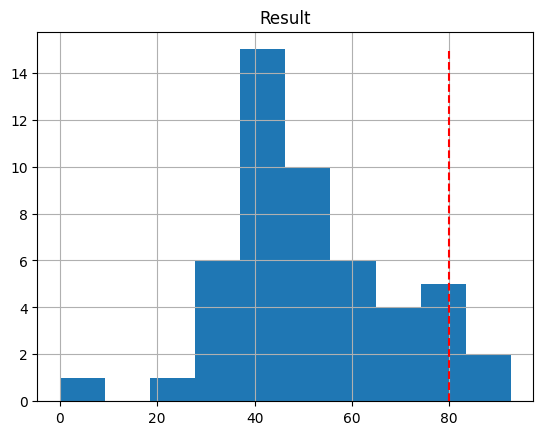

In [28]:
import matplotlib.pyplot as plt
eighty_twenty_check_results.hist(column="Result")
plt.plot([80, 80], [0, 15], linestyle='--', c="red", )